In [1]:
#Importing Libraries
#!pip install torchvision

import torch
import torchvision

import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn, maskrcnn_resnet50_fpn
from PIL import Image, ImageDraw, ImageFont #Python Imaging Library (PIL)
import matplotlib.pyplot as plt
import random

COCO dataset used for object detection https://cocodataset.org/#detection-2016

The COCO (Common Objects in Context) dataset is a large-scale image recognition dataset for object detection, segmentation, and captioning tasks. It contains over 330,000 images, each annotated with 80 object categories and 5 captions describing the scene. The COCO dataset is widely used in computer vision research and has been used to train and evaluate many state-of-the-art object detection and segmentation models.

In [2]:
# class definition for the used classes (from pytorch docs)
COCO_CLASSES = ['__background__', 'person', 'bicycle', 'car', 'motorcycle',
                                'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
                                'fire hydrant', 'stop sign', 'parking meter', 'bench',
                                'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant',
                                'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
                               'handbag', 'tie', 'suitcase', 'frisbee',
                                'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
                                'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
                                'bottle', 'wine glass', 'cup', 'fork', 'knife',
                                'spoon', 'bowl', 'banana', 'apple', 'sandwich',
                                'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
                                'donut', 'cake', 'chair', 'couch', 'potted plant',
                                'bed',  'dining table',
                                'toilet',  'tv', 'laptop', 'mouse',
                                'remote', 'keyboard', 'cell phone', 'microwave',
                                'oven', 'toaster', 'sink', 'refrigerator',  'book',
                                'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


Check the availability of a CUDA-capable GPU (graphics processing unit) in your system. CUDA is a parallel computing platform and application programming interface (API) developed by NVIDIA for utilizing GPUs to accelerate computing tasks, including deep learning.

In [3]:

# Check CUDA availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Currently running on: {device}")

Currently running on: cpu


Loading the Model

In [4]:

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
#model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 79.2MB/s]


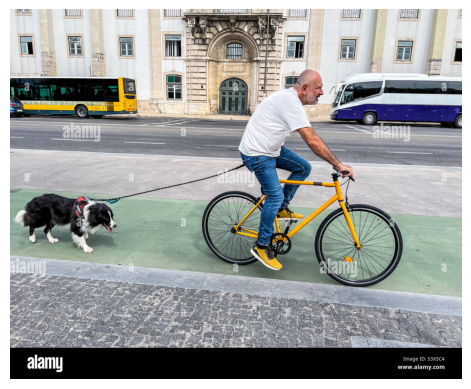

In [25]:

# Load and preprocess the image
image_path = '/content/man-walking-his-dog-while-riding-his-bike-S3X5C4.jpg'
image = Image.open(image_path)
transform = T.Compose([T.ToTensor()])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension


import matplotlib.pyplot as plt

# Convert the image tensor back to a NumPy array
image_np = image_tensor.squeeze(0).permute(1, 2, 0).numpy()

# Display the image
plt.imshow(image_np)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()



In [13]:
#Load and Preprocess the Image

from PIL import Image

def load_and_preprocess_image(img_path):
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img).to(device)
    return img


In [14]:
#Perform Object Detection and Filter Predictions

def perform_object_detection(model, img, threshold):
    model.to(device)
    model.eval()
    pred = model([img])

    # Filter predictions based on threshold
    pred_boxes = pred[0]['boxes'][pred[0]['scores'] > threshold]
    pred_scores = pred[0]['scores'][pred[0]['scores'] > threshold]
    pred_labels = pred[0]['labels'][pred[0]['scores'] > threshold]

    return pred_boxes, pred_scores, pred_labels


In [7]:
#Create a Color Map for Labels

def create_label_color_map(pred_labels):
    label_colors = {}
    for label in pred_labels.unique():
        if label.item() > 0:  # Exclude background label (0)
            label_name = COCO_CLASSES[label.item()]
            label_colors[label_name] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    return label_colors


In [8]:
#Draw Bounding Boxes and Labels

from PIL import ImageDraw, ImageFont

def draw_boxes_and_labels(img, pred_boxes, pred_scores, pred_labels, label_colors):
    font = ImageFont.load_default()
    image_copy = img.permute(1, 2, 0).cpu().numpy() * 255
    image_copy = Image.fromarray(image_copy.astype('uint8'))
    draw = ImageDraw.Draw(image_copy)

    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
        class_name = COCO_CLASSES[label.item()]
        confidence = f'{score:.2f}'
        text = f'{class_name}: {confidence}'
        color = label_colors.get(class_name, 'unknown')  # Get the color based on the label

        # Draw bounding box
        draw.rectangle([box[0], box[1], box[2], box[3]], outline=color, width=3)

        # Calculate text width and height
        text_width, text_height = draw.textsize(text, font=font)

        # Draw filled background for label text
        draw.rectangle([box[0], box[1], box[0] + text_width, box[1] - text_height], fill=color)

        # Draw label text
        draw.text((box[0], box[1] - text_height), text, fill='white', font=font)

    return image_copy


In [23]:
# Load and preprocess the image
img = load_and_preprocess_image('/content/man-walking-his-dog-while-riding-his-bike-S3X5C4.jpg')

# Perform object detection
threshold = 0.5 # Adjust the threshold as needed
pred_boxes, pred_scores, pred_labels = perform_object_detection(model, img, threshold)

# Create a color map for labels
label_colors = create_label_color_map(pred_labels)

# Draw bounding boxes and labels with random colors
output_image = draw_boxes_and_labels(img, pred_boxes, pred_scores, pred_labels, label_colors)



<ipython-input-8-17ff26529dc6>:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-8-17ff26529dc6>:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-8-17ff26529dc6>:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-8-17ff26529dc6>:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-8-17ff26529dc6>:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-

In [24]:
# Save the image with bounding boxes and labels
output_image_path = '/content/outputnew.jpg'
output_image.save(output_image_path)
